In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## BACKGROUND
A company has a fleet of devices transmitting daily telemetry readings. They would like to create a predictive
maintenance solution to proactively identify when maintenance should be performed. This approach promises cost
savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.

## GOAL
You are tasked with building a predictive model using machine learning to predict the probability of a device failure.
When building this model, be sure to minimize false positives and false negatives. The column you are trying to predict
is called failure with binary value 0 for non-failure and 1 for failure.

## DATA
Download link: http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv

Download and read in the dataset

In [2]:
if not os.path.isfile('predictive_maintenance.csv'):
    !wget 'http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv'

In [3]:
df = pd.read_csv('predictive_maintenance.csv', parse_dates =['date'], index_col ='date')
df.head()

,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
date,,,,,,,,,,,
2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


It looks like this is a time series because there is a date column. It looks like there are individual devices that are identified by `device` column. There are 9 `metric` columns.

The task is to predict a failure so lets check and see how the `failure` column is distributed.

In [4]:
df.failure.value_counts()

0    124388
1       106
Name: failure, dtype: int64

This looks like a very imballanced dataset. There are 124,388 nonfailure instanes and 106 failures, which is a failure rate of less than 1%.

Lets see how many unique devices there are and how many of them have failures and how many of them don't have a failure.

In [5]:
total_devices = len(df.device.unique())
print('There are {} total devices'.format(total_devices))

total_failure_devices = len(df[df.failure == 1].device.unique())
print('There are {} total failure devices'.format(total_failure_devices))

There are 1169 total devices
There are 106 total failure devices


It appears that just under 10% of devices have a failure in this data set which is still imbalanced but much less so which viewed this way.

Lets check how the data is distibuted through time.

/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


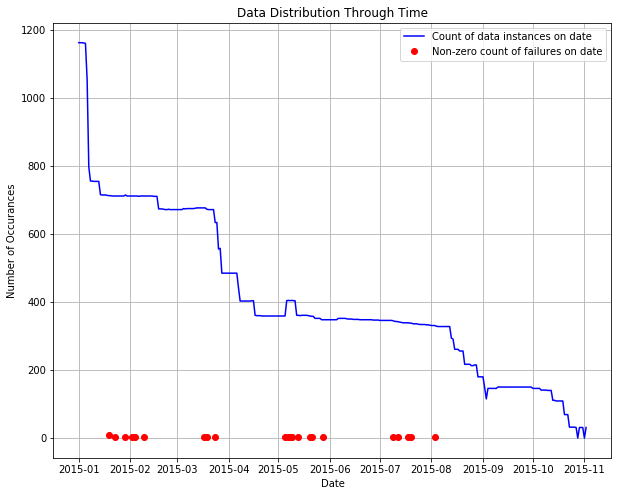

In [6]:
dates = df.failure.resample('D').count().index
values = df.failure.resample('D').count().values
fig, ax = plt.subplots(figsize = (10, 8))
l_counts = ax.plot(dates, values, 'b-', label='Count of data instances on date')

failures = df.failure.resample('D').sum()
failure_dates = failures[failures.values>1].index
failure_values = failures[failures.values>1].values
l_falures = ax.plot(failure_dates, failure_values, 'ro', label='Non-zero count of failures on date')

ax.set_ylabel('Number of Occurances')
ax.set_xlabel('Date')
ax.set_title('Data Distribution Through Time')
ax.grid('on')
_ = ax.legend(loc = 'best')

The data spans less than one year and it is not uniformily distributed through time. It is front loaded. The failures appear to be grouped together but this may or may not be signifigant.

Lets check to see the correlation between variables

In [7]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
failure,1,0.00198348,0.0529016,-0.00094843,0.0673985,0.00226973,-0.000550324,0.119055,0.119055,0.00162157
metric1,0.00198348,1,-0.00424992,0.00370149,0.00183579,-0.00337588,-0.00152197,0.000150676,0.000150676,0.00112075
metric2,0.0529016,-0.00424992,1,-0.00261686,0.146593,-0.0139986,-0.0263496,0.141367,0.141367,-0.00273572
metric3,-0.00094843,0.00370149,-0.00261686,1,0.0974522,-0.0066964,0.00902703,-0.00188394,-0.00188394,0.532366
metric4,0.0673985,0.00183579,0.146593,0.0974522,1,-0.00977282,0.0248699,0.0456309,0.0456309,0.036069
metric5,0.00226973,-0.00337588,-0.0139986,-0.0066964,-0.00977282,1,-0.0170494,-0.00938373,-0.00938373,0.00594942
metric6,-0.000550324,-0.00152197,-0.0263496,0.00902703,0.0248699,-0.0170494,1,-0.0122068,-0.0122068,0.0211525
metric7,0.119055,0.000150676,0.141367,-0.00188394,0.0456309,-0.00938373,-0.0122068,1,1,0.00686067
metric8,0.119055,0.000150676,0.141367,-0.00188394,0.0456309,-0.00938373,-0.0122068,1,1,0.00686067
metric9,0.00162157,0.00112075,-0.00273572,0.532366,0.036069,0.00594942,0.0211525,0.00686067,0.00686067,1


It appears the `metric7` and `metric8` are perfectly correlated with eachother. I will exclude `metric8` from further analysis. None of the variables are particularly well correlated with `failure`. It is interesting that `metric3` and `metric9` have a relatively strong correlation.

In [8]:
df.drop(columns=['metric8'], inplace=True)

## Model Building

Lets try training up some classificaiton models. Because there is such an imbalance in the target variable `failure` some care has to be taken in data split for model training, testing and validation. Also, some thought needs to be put into the correct evaluation metric. Accuracy is the wrong metric because a classifier that predicts no failure every time will have an accuracy above 99%.

In [9]:
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report, recall_score, plot_confusion_matrix, precision_score, f1_score
from sklearn.preprocessing import StandardScaler

# Different classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  depreca

The idea here is to throw a bunch of different classifiers at the problem and see if one works well.

In [10]:
names = ["Nearest Neighbors", "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA", "Logistic Regression", "Stochastic Gradient Descent"]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(),
    SGDClassifier()]

Split our data into predictor variables `X` and response variable `y` and do the train/val/test split. Here we emply the SMOTE algorithm to oversample the minority class. Oversampling of the minority class is chosen because there are are so few instances of failures. We then also scale the resampled data and then do a test train split.

In [11]:
y = df.failure

df_train, df_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)

df_train, df_val, y_train, y_val = train_test_split(df_train, y_train, test_size=0.2, random_state=1)

# Remove device from X_train, X_test
X_train = df_train.filter(regex='metric', axis='columns')
X_val = df_val.filter(regex='metric', axis='columns')
X_test = df_test.filter(regex='metric', axis='columns')

# Rescale and oversample the train data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

# Oversample minority class
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

# Scale the test data from the training data scaler
X_test = scaler.transform(X_test)

/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Now we loop over all over all of our classifiers and check the recall primarily but also to precision and the confusion matrix.

Nearest Neighbors
training...
predicting...
scoring...
Recall: 0.15789473684210525
Precision: 0.01775147928994083


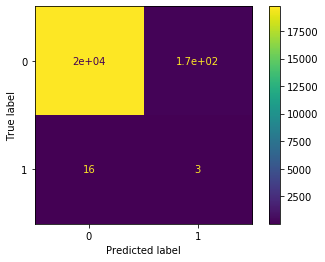

Decision Tree
training...
predicting...
scoring...
Recall: 0.3684210526315789
Precision: 0.006145741878841089


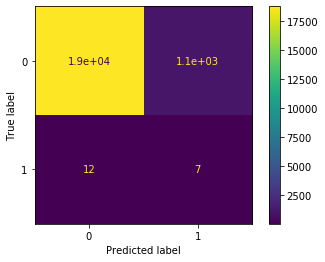

Random Forest
training...
predicting...
scoring...
Recall: 0.5789473684210527
Precision: 0.006931316950220542


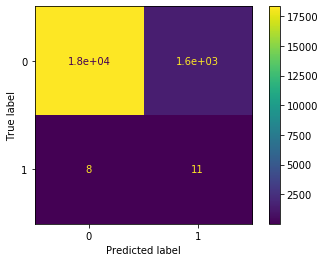

Neural Net
training...
predicting...
scoring...
Recall: 0.5789473684210527
Precision: 0.00857365549493375


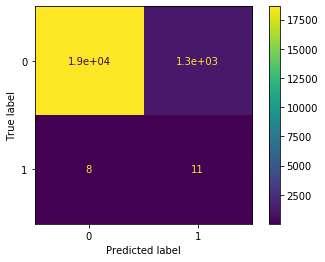

AdaBoost
training...
predicting...
scoring...
Recall: 0.3684210526315789
Precision: 0.0075107296137339056


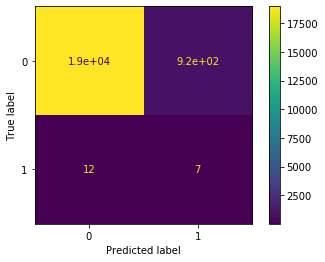

Naive Bayes
training...
predicting...
scoring...
Recall: 0.3684210526315789
Precision: 0.0319634703196347


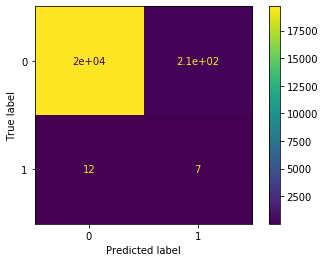

QDA
training...
predicting...
scoring...
Recall: 0.3684210526315789
Precision: 0.032407407407407406


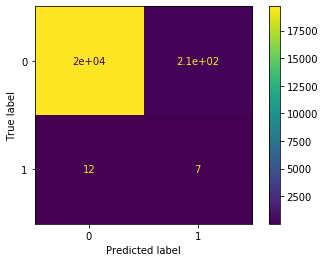

Logistic Regression
training...
predicting...
scoring...
Recall: 0.42105263157894735
Precision: 0.011412268188302425


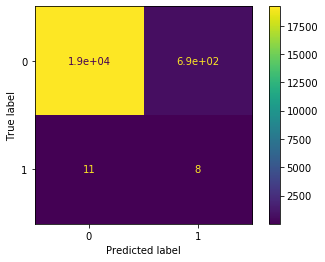

Stochastic Gradient Descent
training...
predicting...
scoring...
Recall: 0.47368421052631576
Precision: 0.010869565217391304


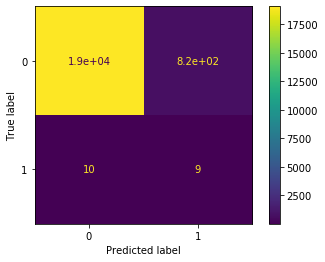

In [12]:
# iterate over classifiers
for name, clf in zip(names, classifiers):
    print(name)
    print('training...')
    clf.fit(X_resampled, y_resampled)
    print('predicting...')
    predictions = clf.predict(X_val)
    print('scoring...')
    print('Recall: {}'.format(recall_score(y_val, predictions)))
    print('Precision: {}'.format(precision_score(y_val, predictions)))
    plot_confusion_matrix(clf, X_val, y_val)
    plt.show()

## Can we do better?
The goal of the company is "They would like to create a predictive maintenance solution to proactively identify when maintenance should be performed". The predictive models that were developed above simply say if there has been a failure or not. In reality this likely isn't very useful in a proactive sense, but it was a nice warmup to the problem and to get a general sense of the data set.

Ideally, a solution to this will not just tell that there is a failure, but also _how long_ until the failure will happen so there is time to schedule the needed maintenence. To do this we will engineer another column called `fails_n_days` and build a model to predict this value.

## Days to failure

Now we are going to try and predict `fails_n_days`. To do this we develop a convenience function to engineer the near feature we are trying to predict.

In [13]:
def find_fails_n_days(df_device, days_to_fail=30):
    '''Computes the number of days till a failure for a given device. Returns a boolean array where 1 indicates
    a failure withing `days_to_fail` number of days and 0 otherwise.
    
    Input:
        df_device: A dataframe of one device
        days_to_fail: The number of days that you are looking ahead for a failure
        
    Return:
        to_failure: A boolean array 
    '''
    fail_date = df_device[df_device.failure == 1].index
    if len(fail_date) < 1:
        to_failure = np.zeros((len(df_device),))
    else:
        to_failure = []
        for date in df_device.index:
            observation = (fail_date - date).days
            if observation > days_to_fail:
                failure_boolean = 0
            else:
                failure_boolean = 1
            to_failure.append(failure_boolean)
    return to_failure

In [14]:
initial_fails_n_days = np.zeros(len(df))
df['fails_n_days'] = initial_fails_n_days
for device in df.device.unique():
    df_device = df[df.device == device]
    device_fails_n_days = find_fails_n_days(df_device)
    df.loc[df.device == device, ['fails_n_days']] = device_fails_n_days

Lets take a look at how this feature turned out

In [15]:
df.fails_n_days.value_counts()

0.0    121635
1.0      2859
Name: fails_n_days, dtype: int64

This minority of this new prediction column is still imballanced but it is much less imballanced than before. Also, it give some sense of _how long_ until a failure will occur which is the goal of this project.

Lets again train some classification models and see how they do now.

In [16]:
# New predictor column
y = df.fails_n_days

df_train, df_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)

df_train, df_val, y_train, y_val = train_test_split(df_train, y_train, test_size=0.2, random_state=1)

# Remove device from X_train, X_test
X_train = df_train.filter(regex='metric', axis='columns')
X_val = df_val.filter(regex='metric', axis='columns')
X_test = df_test.filter(regex='metric', axis='columns')

# Rescale and oversample the train data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

# Scale the test data from the training data scaler
X_test = scaler.transform(X_test)

Nearest Neighbors
training...
predicting...
scoring...
Recall: 0.29411764705882354
Precision: 0.693069306930693



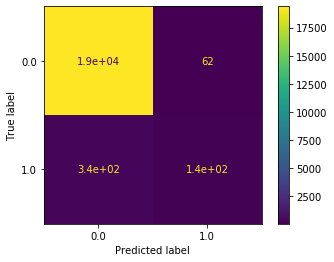

Decision Tree
training...
predicting...
scoring...
Recall: 0.1722689075630252
Precision: 0.7961165048543689



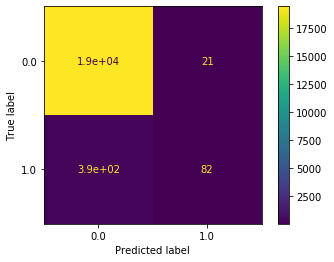

Random Forest
training...
predicting...
scoring...
Recall: 0.008403361344537815
Precision: 1.0



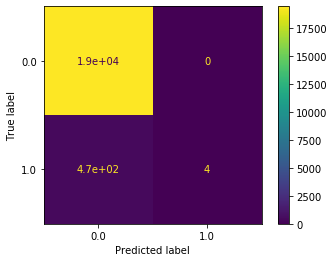

Neural Net
training...
predicting...
scoring...
Recall: 0.0
Precision: 0.0



/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


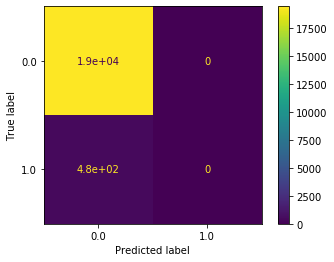

AdaBoost
training...
predicting...
scoring...
Recall: 0.1092436974789916
Precision: 0.5306122448979592



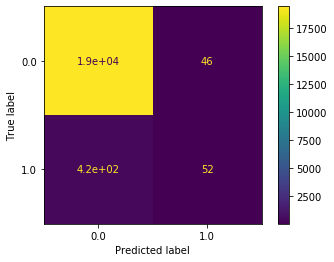

Naive Bayes
training...
predicting...
scoring...
Recall: 0.15336134453781514
Precision: 0.37244897959183676



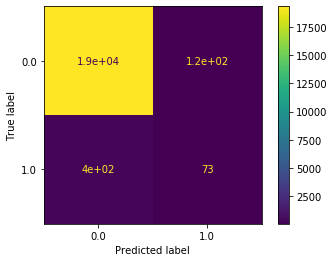

QDA
training...
predicting...
scoring...
Recall: 0.15336134453781514
Precision: 0.36318407960199006



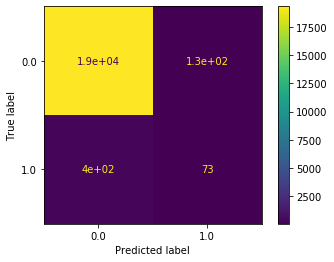

Logistic Regression
training...
predicting...
scoring...
Recall: 0.012605042016806723
Precision: 0.46153846153846156



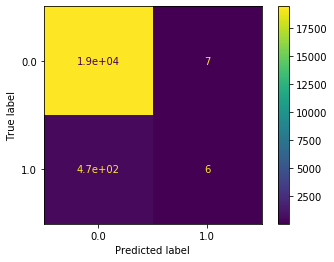

Stochastic Gradient Descent
training...
predicting...
scoring...
Recall: 0.0
Precision: 0.0



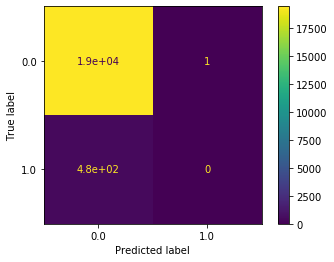

In [17]:
# iterate over classifiers
for name, clf in zip(names, classifiers):
    print(name)
    print('training...')
    clf.fit(X_train, y_train)
    print('predicting...')
    predictions = clf.predict(X_val)
    print('scoring...')
    print('Recall: {}'.format(recall_score(y_val, predictions)))
    print('Precision: {}\n'.format(precision_score(y_val, predictions)))
    plot_confusion_matrix(clf, X_val, y_val)
    plt.show()

## Are we asking the right question?

Are we evaluating this correctly? I think a more meaningful evaluation would be to sort devices into false positive, meaning a failure was predicted without one occuring, and then true positive with a difference between first predicted failure and actual predicted failure date and look and this.

In [18]:
def calculate_days_missed(df_device, predictions):
    '''Calculate the difference between when a failure is pfirst predicted to occur and vs when it actually occurs
    
    Input:
        df_device: A dataframe with all readings for a particular device
        predictions: The boolean array that predicts when a failure will occur
        
    Return:
        days_missed: The difference in days between a first prediction of a failure and the actual failure
    '''
    device_index = df_device.index
    fail_date = df_device[df_device.failure == 1].index[0]
    first_predicted_fail = next((i for i, x in enumerate(list(predictions)) if x), None)
    first_predicted_fail_date = device_index[first_predicted_fail]
    date_difference = fail_date - first_predicted_fail_date
    days_missed = float(date_difference.days)
    return days_missed

def evaluate_device_classification(df_test, clf, scaler):
    '''A convenince function to evaluate the performance of a classifier on a per device basis as 
    opposed to a per device and per day basis
    
    Input:
        df_test: A dataframe with the test data
        clf: The classification model that is being evaluated
        scaler: A scaler object to scale the test data based on a training set
        
    Returns:
        devices: A list of devices under test
        device_fail_truth: A boolean array that shows if a device failed or not
        device_fail_predictions: A boolean array that shows the predicted failure of a device
        true_postive_error: An array with the number of days between when a failure was predicted 
                            vs when it actually occured
    '''
    true_postive_error = []
    devices = []
    device_fail_predictions = []
    device_fail_truth = []
    for device in df_test.device.unique():
        devices.append(device)
        df_device = df_test[df_test.device == device]
        X_device = scaler.transform(df_device.filter(regex='metric', axis='columns'))
        y_device = clf.predict(X_device)

        # True positives
        if sum(df_device.failure) > 0 and sum(y_device) > 0:
            num_days_missed = calculate_days_missed(df_device, y_device)            
            true_postive_error.append(num_days_missed)
            device_fail_predictions.append(1)
            device_fail_truth.append(1)
        # False positives
        elif sum(df_device.failure) == 0 and sum(y_device) > 0:
            device_fail_predictions.append(1)
            device_fail_truth.append(0)
        # False negatives
        elif sum(df_device.failure) > 0 and sum(y_device) == 0:
            device_fail_predictions.append(0)
            device_fail_truth.append(1)
        # True negatives
        else:
            device_fail_predictions.append(0)
            device_fail_truth.append(0)
    return devices, device_fail_truth, device_fail_predictions, true_postive_error

In [23]:
for name, clf in zip(names, classifiers):
    print(name)
    print('training...')
    clf.fit(X_train, y_train)

    print('Predicting for each device...')
    devices, device_fail_truth, device_fail_predictions, true_postive_error = evaluate_device_classification(df_val, clf, scaler)
    
    print('Confusion matrix')
    print(confusion_matrix(device_fail_truth, device_fail_predictions))
    print('\nRecall: {}'.format(recall_score(device_fail_truth, device_fail_predictions)))
    print('Precision: {}'.format(precision_score(device_fail_truth, device_fail_predictions)))
    print('Average days missed: {}'.format(np.mean(true_postive_error)))
    print('Std days missed: {}\n'.format(np.std(true_postive_error)))

Nearest Neighbors
training...
Predicting for each device...
Confusion matrix
[[940  84]
 [  6  13]]

Recall: 0.6842105263157895
Precision: 0.13402061855670103
Average days missed: 16.0
Std days missed: 14.811637835992865

Decision Tree
training...
Predicting for each device...
Confusion matrix
[[998  26]
 [ 15   4]]

Recall: 0.21052631578947367
Precision: 0.13333333333333333
Average days missed: 4.0
Std days missed: 6.363961030678928

Random Forest
training...
Predicting for each device...
Confusion matrix
[[1020    4]
 [  18    1]]

Recall: 0.05263157894736842
Precision: 0.2
Average days missed: 15.0
Std days missed: 0.0

Neural Net
training...
Predicting for each device...
Confusion matrix
[[1024    0]
 [  19    0]]

Recall: 0.0
Precision: 0.0
Average days missed: nan
Std days missed: nan

AdaBoost
training...


/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/U

Predicting for each device...
Confusion matrix
[[991  33]
 [ 17   2]]

Recall: 0.10526315789473684
Precision: 0.05714285714285714
Average days missed: 0.0
Std days missed: 0.0

Naive Bayes
training...
Predicting for each device...
Confusion matrix
[[985  39]
 [ 13   6]]

Recall: 0.3157894736842105
Precision: 0.13333333333333333
Average days missed: 0.6666666666666666
Std days missed: 1.1055415967851334

QDA
training...
Predicting for each device...
Confusion matrix
[[985  39]
 [ 13   6]]

Recall: 0.3157894736842105
Precision: 0.13333333333333333
Average days missed: 0.6666666666666666
Std days missed: 1.1055415967851334

Logistic Regression
training...
Predicting for each device...
Confusion matrix
[[1018    6]
 [  19    0]]

Recall: 0.0
Precision: 0.0
Average days missed: nan
Std days missed: nan

Stochastic Gradient Descent
training...
Predicting for each device...


/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/dueghis/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Confusion matrix
[[1011   13]
 [  15    4]]

Recall: 0.21052631578947367
Precision: 0.23529411764705882
Average days missed: 0.75
Std days missed: 1.299038105676658



So it appears that out of the box, Nearest Neighbors has the best recall and it also is able to predict that a failure will occur the farthest in the furture, 19 days on average. Lets do some hyperparameter tuning and see if we can make it even better.

In [25]:
import itertools
grid_n_neighbors = [1, 3, 5]
grid_weights = ['uniform', 'distance']
grid_p = [1, 2]
grid_params = [grid_n_neighbors, grid_weights, grid_p]
best_score = 0
best_params = None
best_true_positive_error = None

for params in itertools.product(*grid_params):
    print('\nTrying params: {}'.format(params))
    n_neighbors = params[0]
    weights = params[1]
    algorithm = 'auto'
    p = params[2]
    n_jobs = -1
    clf = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        p=p,
        n_jobs=n_jobs
    )
    print('training...')
    clf.fit(X_train, y_train)
    print('testing per device...')
    devices, device_fail_truth, device_fail_predictions, true_postive_error = evaluate_device_classification(df_val, clf, scaler)
    score = recall_score(device_fail_truth, device_fail_predictions)
    print('Recall: {}'.format(score))
    print('Confusion matrix')
    print(confusion_matrix(device_fail_truth, device_fail_predictions))
    if score > best_score:
        print('##### Best Recall: {}\n'.format(score))
        best_score = score
        best_params = params
        best_true_positive_error = true_postive_error


Trying params: (1, 'uniform', 1)
training...
testing per device...
Recall: 0.8947368421052632
Confusion matrix
[[858 166]
 [  2  17]]
##### Best Recall: 0.8947368421052632


Trying params: (1, 'uniform', 2)
training...
testing per device...
Recall: 0.7894736842105263
Confusion matrix
[[853 171]
 [  4  15]]

Trying params: (1, 'distance', 1)
training...
testing per device...
Recall: 0.8947368421052632
Confusion matrix
[[858 166]
 [  2  17]]

Trying params: (1, 'distance', 2)
training...
testing per device...
Recall: 0.7894736842105263
Confusion matrix
[[853 171]
 [  4  15]]

Trying params: (3, 'uniform', 1)
training...
testing per device...
Recall: 0.7368421052631579
Confusion matrix
[[943  81]
 [  5  14]]

Trying params: (3, 'uniform', 2)
training...
testing per device...
Recall: 0.6842105263157895
Confusion matrix
[[940  84]
 [  6  13]]

Trying params: (3, 'distance', 1)
training...
testing per device...
Recall: 0.7894736842105263
Confusion matrix
[[912 112]
 [  4  15]]

Trying param

OK we have found our best parameters, lets see how it does on the test data.

In [27]:
# New predictor column
y = df.fails_n_days

df_train, df_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)

# Remove device from X_train, X_test
X_train = df_train.filter(regex='metric', axis='columns')
X_test = df_test.filter(regex='metric', axis='columns')

# Rescale the train data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Scale the test data from the training data scaler
X_test = scaler.transform(X_test)

In [28]:
clf = KNeighborsClassifier(
        n_neighbors=1,
        weights='uniform',
        algorithm='auto',
        p=1,
        n_jobs=n_jobs
    )
print('training...')
clf.fit(X_train, y_train)
print('testing per device...')
devices, device_fail_truth, device_fail_predictions, true_postive_error = evaluate_device_classification(df_test, clf, scaler)
score = recall_score(device_fail_truth, device_fail_predictions)
print('Recall: {}'.format(score))
print('Confusion matrix')
print(confusion_matrix(device_fail_truth, device_fail_predictions))

training...
testing per device...
Recall: 0.8
Confusion matrix
[[873 173]
 [  4  16]]


38.25


Text(0.5, 0, 'Days to Fail')

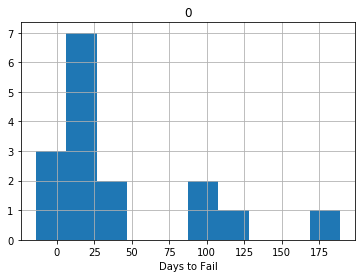

In [32]:
pd.DataFrame(true_postive_error).hist()
print(np.mean(true_postive_error))
plt.xlabel('Days to Fail')

It appears that there is a wide variety in the predictive power of the model. The average lead time to failure is 38 days but tthere are some instances where a failure was predicted over 50 days into the future. This may or may not be helpful for the business.

## Final thoughts

This was a first pass at a predictive maintenence solution. It seems to have worked in the sense that this model gave guidance to how long a device had until a failure based on the different metrics. Before I would be comfortable delivering this as a final model, I would like to understand the respective penalty between predicting a failure that wont occur and not predicting a failure that will occur. Understand these costs in the greatest detail will allow for the most finlly tuned model possible.

Also, this is just one method to attempt to solve this problem. Other methods could be to employ survival analysis in the form of a Cox Regression. Also some kind of RNN could have been developed to see if it performed better than the classical machine learning methods that were employed. The solution to a data science problem can always be improved in any number of ways.